# Rainier DEM Example

Since we are gathered here in Seattle, let’s play with some high-resolution DEMs of our friendly, neighborhood stratovolcano, Mount Rainier (AKA Tahoma). 

Can we use these DEMs calculate long-term and recent glacier elevation and volume change?

In [1]:
#Allow for interactive figure display
%matplotlib notebook
#%matplotlib inline

In [2]:
#Import necessary modules
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt
import os
import numpy.ma as ma
from os.path import isfile, join

from pygeotools.lib import iolib, warplib, geolib, timelib, malib
# timelib does time series analysis

### DEM sources:

- 1-arcsec (30-m) USGS National Elevation Dataset derived from digitized contour maps with 1970 source date (I merged several tiles and clipped to a large extent around Rainier)
- 10-m airborne LiDAR data from 2007/2008 (original LiDAR was on 1-m grid, I subsampled for this exercise)
- 8-m DEM derived from WorldView Stereo imagery acquired on August 8, 2015

These may look similar at this scale, but there are subtle differences in the projeciton, extent, and resolution. So how can we compute elevation change using a uniform grid?

### Enter pygeotools warplib

GDAL provides all of the machinery needed to solve this problem. From the command line, one could use gdalwarp or gdal_translate to preprocess all input datasets to a common projection, extent, and resolution. But what if you want to do this within a Python, or do on-the-fly analysis for a subset, without the unnecessary, potentially time-consuming steps to read/write warped files from/to disk?

The pygeotools libraries contains a number of functions built around the GDAL Python API. Several options make raster warping operations simple, especially for preparing a uniform timeseries "stack" from an arbitrary number of input rasters. The warptool.py script offers a command-line interface (see usage by running `wartool.py --help`), while the lib/warplib.py library contains the underlying functions. For this tutorial, we will use the memwarp functions in lib/warplib.py to prepare warped in-memory versions of our input DEMs that we can then difference to study elevation change over time. Then, if there’s time, we’ll use NumPy and a few other pygeotools tricks to pull out some estimates for glacier volume and mass change.

In [3]:
#Input DEM filenames
#dem_1970_fn = '../data/rainier/19700901_ned1_2003_adj_warp.tif'
#dem_2008_fn = '../data/rainier/20080901_rainierlidar_10m-adj.tif'
#dem_2015_fn = '../data/rainier/20150818_rainier_summer-tile-0.tif'
#dem_fn_list = [dem_1970_fn, dem_2008_fn, dem_2015_fn]

#dem_2003_fn = 'orig_DEM_32m/20030507_0445_1010010001E01600_1010010001E01500-DEM_32m.tif'
#dem_2010_fn = 'orig_DEM_32m/20100220_0508_1030010004C8E000_1030010004245100-DEM_32m.tif'
#dem_2014_fn = 'orig_DEM_32m/20140214_0449_102001002C122A00_102001002D5E9300-DEM_32m.tif'
#dem_2016_fn = 'orig_DEM_32m/20160211_0512_104001001854B000_10400100175C2D00-DEM_32m.tif'

#onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

mypath = 'data'

filenames = os.listdir(mypath)

dem_fn_list = [join(mypath, f) for f in filenames if isfile(join(mypath, f))]
dem_fn_list = sorted(dem_fn_list)
print(dem_fn_list)

#dem_2003_fn = 'data/20030507_0445_1010010001E01600_1010010001E01500-DEM_32m_trans.tif'
#dem_2012_fn = 'data/20121228_0506_102001001FB33300_102001002097D600-DEM_32m_trans.tif'
#dem_2014_fn = 'data/20140303_0447_1020010029AC1C00_102001002BD01800-DEM_32m_trans.tif'
#dem_2016_fn = 'data/20160211_0512_104001001854B000_10400100175C2D00-DEM_32m_trans.tif'

#dem_fn_list = [dem_2003_fn, dem_2012_fn, dem_2014_fn, dem_2016_fn]




# or

#class RasterSource(object):
#    FILE_ENDING = 'trans.tif'

#    def __init__(self, folder):
#        self._folder = folder

#    def file_list(self):
#        return glob.glob(
#            os.path.join(self._folder, '') + '**/*' + self.FILE_ENDING,
#            recursive=True
#        )
#RasterSource('data/khumbu_DEM_32m/').file_list() 

['data/20030507_0445_1010010001E01600_1010010001E01500-DEM_32m_trans.tif', 'data/20121223_0456_1050410000E0AE00_1050410000E8C900-DEM_32m_trans.tif', 'data/20121228_0506_102001001FB33300_102001002097D600-DEM_32m_trans.tif', 'data/20130106_0456_102001001D141500_102001001DC53200-DEM_32m_trans.tif', 'data/20131229_0456_10200100296A0900_10200100298D5F00-DEM_32m_trans.tif', 'data/20140303_0447_1020010029AC1C00_102001002BD01800-DEM_32m_trans.tif', 'data/20140307_0452_102001002C5CED00_102001002CCB4600-DEM_32m_trans.tif', 'data/20140311_0458_102001002CDDFB00_102001002CE68A00-DEM_32m_trans.tif', 'data/20140311_0520_103001002E546F00_103001002C956F00-DEM_32m_trans.tif', 'data/20140324_0453_102001002D263400_102001002C1E2100-DEM_32m_trans.tif', 'data/20140514_0454_102001003001E400_102001002F6B1000-DEM_32m_trans.tif', 'data/20141018_0511_1050410011888400_1050410011888300-DEM_32m_trans.tif', 'data/20141022_0518_1020010036518E00_102001003525D400-DEM_32m_trans.tif', 'data/20150115_0456_1040010006A12900_

OK, time for some warpin’. We are going to use the memwarp_multi_fn function, which accepts a list of raster filenames and allows the user to specify a desired output extent, resolution, and projection for each output in-memory GDAL dataset. In this case, we will clip everything to a common intersection, use the minimum (best) resolution, and preserve the projection of our 2015 DEM (in this case, UTM 10N, EPSG:32610). See the warptool.py usage for the range of valid inputs for the extent, res, and t_srs options.

The following will return warped, in-memory GDAL dataset objects. The key parameters are extent, res, and t_srs (projection):

- In this case, we want to clip all DEMs to the same common extent (extent='intersection')
- Let’s use the minimum (highest) resolution from all input DEMs (res='min')
- And let’s use the projection of the 2015 Stereo DEMs, in this case, just specify the filename (t_srs=dem_2015_fn)

Note: could also resample all inputs to a lower resolution for testing (e.g., use keyword argument res=128)

In [4]:
#ds_list = warplib.memwarp_multi_fn(dem_fn_list, extent='intersection', res='min', t_srs=dem_2015_fn)

ds_list = warplib.memwarp_multi_fn(dem_fn_list, extent='union', res='min', t_srs=dem_fn_list[-1])


Warping all inputs to the following:
Resolution: 32.0
Extent: [473230.772, 3085731.302, 497009.303, 3103537.631]
Projection: '+proj=utm +zone=45 +datum=WGS84 +units=m +no_defs '
Resampling alg: cubic

1 of 29: data/20030507_0445_1010010001E01600_1010010001E01500-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
2 of 29: data/20121223_0456_1050410000E0AE00_1050410000E8C900-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
3 of 29: data/20121228_0506_102001001FB33300_102001002097D600-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
4 of 29: data/20130106_0456_102001001D141500_102001001DC53200-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
5 of 29: data/20131229_0456_10200100296A0900_10200100298D5F00-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
6 of 29: data/20140303_0447_1020010029AC1C00_102001002BD01800-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
7 of 29: data/20140307_0452_102001002C5CED00_102001002CCB4600-DEM_32m_trans.tif
nl: 556 ns: 743 res: 32.000
8 of 29: data/20140311_0458_102001002CDDFB

That’s it. Note that warplib includes some shortcuts to avoid unnecessary warping if one of the input datasets already meets the output criteria.

Now we have a list of warped, consistent GDAL datsets for analysis. Let’s use the iolib.ds_getma function to load the datasets into NumPy masked arrays. Under the hood, this runs GDAL ReadAsArray and thne intelligently masks NoData values.

In [5]:
#Load datasets to NumPy masked arrays
#dem_1970, dem_2008, dem_2015 = [iolib.ds_getma(i) for i in ds_list]
#dem_list = [dem_1970, dem_2008, dem_2015]

#dem_2003, dem_2012, dem_2014, dem_2016 = [iolib.ds_getma(i) for i in ds_list]
#dem_list = [dem_2003, dem_2012, dem_2014, dem_2016]
dem_list = [iolib.ds_getma(i) for i in ds_list]

In [6]:
#Print some output info
#print(dem_2015.shape)
#print(dem_2015.dtype)

#dem_2015

print(dem_list[0].shape)
print(dem_list[0].dtype)

print(ds_list[0])

# It's masked to make sure that NA are viewed as NA in all different datasets, without deleting them

(556, 743)
float32
<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7f723bf75c90> >


OK, our array has 2855 rows, 3101 columns and the values are float32.

The print(dem_2015) command prints the first and last three rows (lines) and columns (samples) of the raster data, and then the first and last three rows/columns of the mask. Note that where the mask values are True, there was no valid raster data.

Wikipedia says the summit is 14411 ft above sea level.  How high is the summit elevation in each DEM?

Since we know the summit is the hightest elevation in our domain, we can use the NumPy argmax function to find the corresponding array (row,col) indices of that maximum elevation value.  We can then extract the corresponding elevations for that location in the other arrays.

In [7]:
#Get the array index of the maximum elevation
#summit_idx = np.unravel_index(dem_2008.argmax(), dem_2008.shape)
#for dem in dem_list:
#    print(summit_idx)
#    print('%0.1f m (%0.1f ft)' % (dem[summit_idx], (dem[summit_idx]*3.28084)))
    

    

#summit_idx = np.unravel_index(dem_list[0].argmin(), dem_list[0].shape)

# Picking a pixel of interest

#interest_idx = (184, 429)
interest_idx = (184, 329)

times = []
for dem in dem_list:
    #print(summit_idx)
    #print('%0.1f m (%0.1f ft)' % (dem[summit_idx], (dem[summit_idx]*3.28084)))
    times.append(dem.data[interest_idx])
    
t_list = np.array([timelib.fn_getdatetime(fn) for fn in dem_fn_list])
# If we want to convert the time stamp to decimal years (not necessary)
#t_list = [timelib.dt2decyear(t) for t in t_list]

times=np.array(times)
#times = ma.masked_invalid(times)


In [8]:
#fig = plt.Figure()
plt.figure(1)
plt.subplot(111)
#plt.plot(np.array(t_list), np.array(times))
#plt.plot(np.array(t_list)[~times.mask], times[~times.mask])
plt.plot(np.array(t_list)[times!=0], times[times!=0])
plt.xlabel('time')
plt.ylabel('elevation')
plt.title('Elevation per pixel')
plt.savefig("elevation_per_pixel.png")
plt.show()

<IPython.core.display.Javascript object>

In [9]:
#khumbu_shp_mask = geolib.shp2array(khumbu_shape_filename, dataset_list[0])
#plt.imshow(np.ma.array(coverage, mask=khumbu_shp_mask))

In [72]:
from sklearn import linear_model

change = np.zeros(dem_list[0].data.shape)

# figuring out the pixels indices that are on the glacier
glacier_area = np.ones(dem_list[0].data.shape)

khumbu_shape_filename = "khumbu_shape/khumbu_shape.shp"
khumbu_shp_mask = geolib.shp2array(khumbu_shape_filename, ds_list[0])
#plt.imshow(np.ma.array(change, mask=khumbu_shp_mask))
masked_glacier_area = np.ma.array(glacier_area, mask=khumbu_shp_mask)

masked_glacier_aoi = masked_glacier_area.nonzero()

# Getting the pixel coordinates
idx_vec = []
for i in range(0, len(masked_glacier_aoi[0])):
    idx_vec.append((masked_glacier_aoi[0][i],masked_glacier_aoi[1][i]))

print("number of pixels " + str(len(masked_glacier_aoi[0])))

#idx_vec = [(184, 429), (184, 329), (250, 429)]


# getting the vector of times
t_list = np.array([timelib.fn_getdatetime(fn) for fn in dem_fn_list])
# As fractions of year
t_list_num =np.array([timelib.dt2decyear(t) for t in t_list])[1:]

# initializing the plot
#fig, ax = plt.subplots()

# computing the slope for every pixel in the idx_vec
for idx in idx_vec:
    #print(idx)
    elevation = []
    for dem in dem_list[1:]:
        elevation.append(dem.data[idx])
        
    elevation=np.array(elevation)
    
    
    glacier_x = t_list_num[elevation!=0]
    glacier_y = elevation[elevation!=0]
    
    #print(glacier_x.max())
    
    #if len(glacier_x)>4:
    if glacier_x.max() - glacier_x.min() > 0: # time spans more than 2 years
        #plt.plot(glacier_x, glacier_y)
    
        # Create linear regression object
        regr = linear_model.LinearRegression()

        # Train the model using the training sets
        regr.fit(glacier_x.reshape(-1, 1), glacier_y.reshape(-1, 1))

        # The coefficients
        #print('Coefficients: \n', regr.coef_[0])
        change[idx] = regr.coef_[0]

#plt.plot(glacier_x, glacier_y)
#plt.ylim((5000,7000))
#plt.xlabel('time')
#plt.ylabel('elevation')
#plt.title('Elevation per pixel')
#plt.savefig("elevation_per_pixel.png")
#plt.show()

Input shp srs: +proj=longlat +datum=WGS84 +no_defs 
Specified output srs: +proj=utm +zone=45 +datum=WGS84 +units=m +no_defs 
number of pixels 18649


<IPython.core.display.Javascript object>


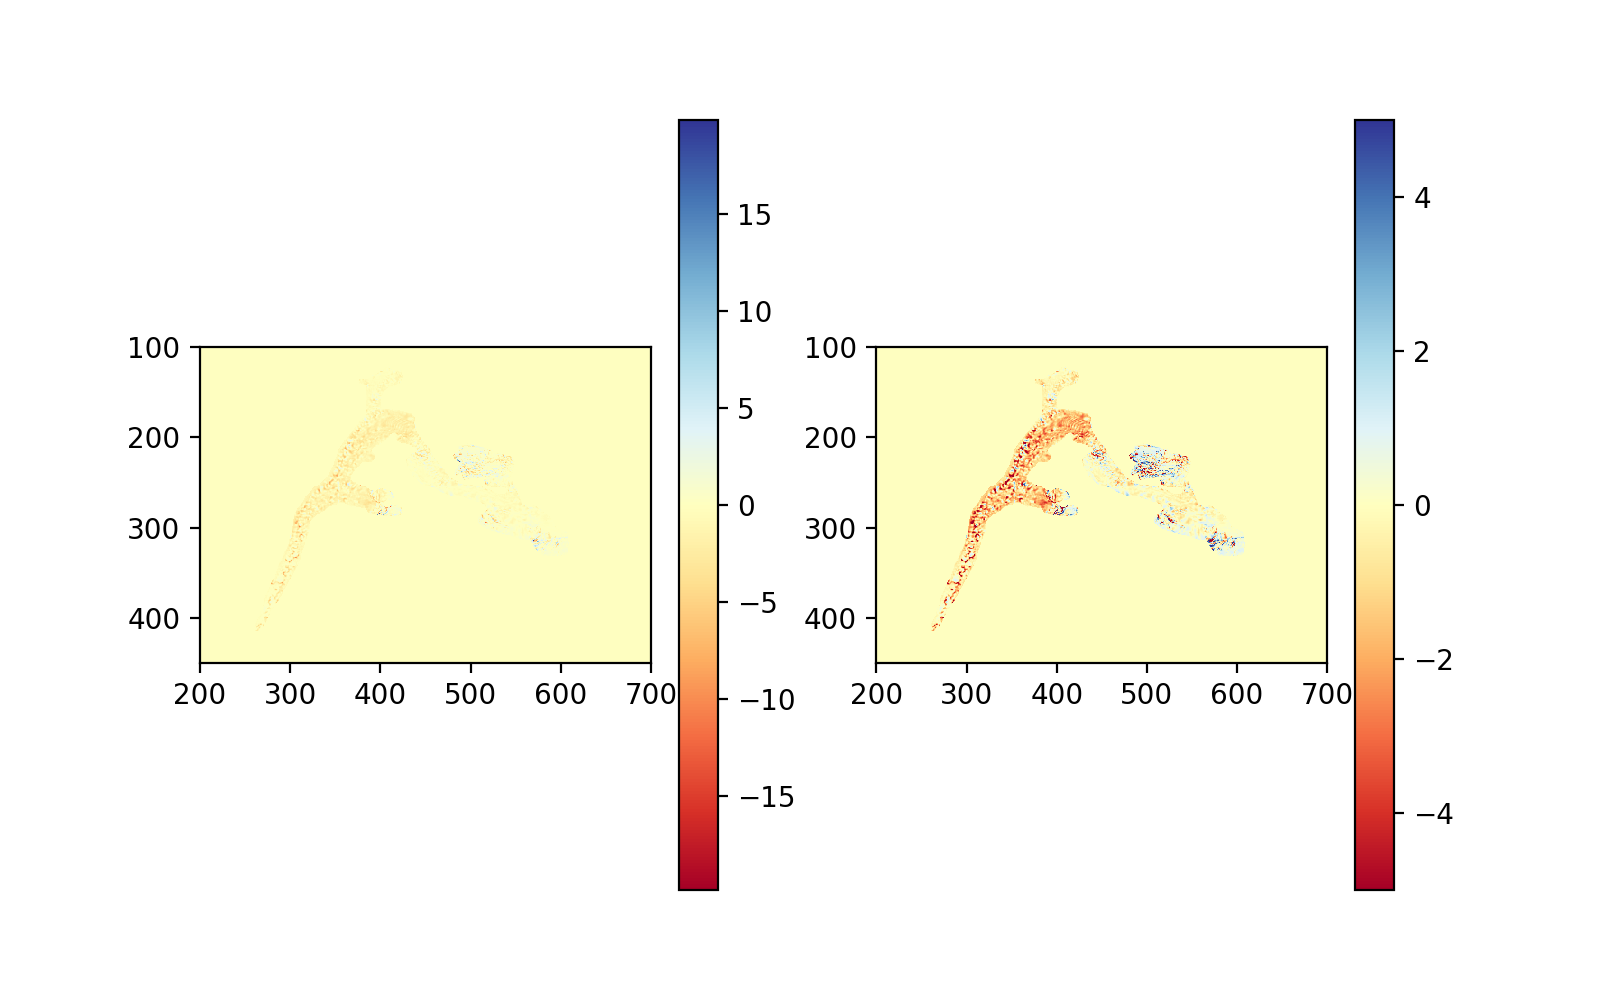

In [73]:
fig = plt.figure(figsize = (8,5))
ax = plt.subplot(1, 2, 1)
plt.imshow(change, cmap='RdYlBu', vmin = -np.abs(change).max())
plt.xlim((200, 700))
plt.ylim((450, 100))
plt.colorbar()
ax = plt.subplot(1, 2, 2)
plt.imshow(change, cmap='RdYlBu', vmin=-5, vmax=5)
plt.xlim((200, 700))
plt.ylim((450, 100))
plt.colorbar()

In [12]:
dem_list[0]
summit_idx = np.unravel_index(dem_list[0].argmin(), dem_list[0].shape)

Note: Mt. Rainier is not sinking.  These values are relative to the WGS84 ellipsoid datum, not a geoid model (e.g., NAVD88, which approximates mean sea level).  

Note 2: You can calculate the mean geoid offset for a given dataset, or a (lon,lat) location using `geolib.get_geoid_offset` method.  But this requires that you download some geoid offset grids (http://download.osgeo.org/proj/vdatum/), so we're going to skip that.  For reference, the geoid offset at Rainier is approximately 18.79 m.  Adding that to our height above WGS84 ellipsoid, comes to 4392.5 m (14411 ft).  All is well.

OK, we have some numbers, but I like colorful pictures, so let’s visualize this array of numbers as an image.  We'll first define a function to create a matplotlbi plot with 3 subplots for each DEM.

In [13]:
#Function to generate a 3-panel plot for input arrays
def plot3panel(dem_list, clim=None, titles=None, cmap='inferno', label=None, overlay=None, fn=None):
    fig, axa = plt.subplots(1,3, sharex=True, sharey=True, figsize=(10,4))
    alpha = 1.0
    for n, ax in enumerate(axa):
        #Gray background
        ax.set_facecolor('0.5')
        #Force aspect ratio to match images
        ax.set(aspect='equal')
        #Turn off axes labels/ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        if titles is not None:
            ax.set_title(titles[n])
        #Plot background shaded relief map
        if overlay is not None:
            alpha = 0.7
            axa[n].imshow(overlay[n], cmap='gray', clim=(1,255)) 
    #Plot each array 
    im_list = [axa[i].imshow(dem_list[i], clim=clim, cmap=cmap, alpha=alpha) for i in range(len(dem_list))]
    fig.tight_layout()
    fig.colorbar(im_list[0], ax=axa.ravel().tolist(), label=label, extend='both', shrink=0.5)
    if fn is not None:
        fig.savefig(fn, bbox_inches='tight', pad_inches=0, dpi=150)
    plt.show()

In [14]:
#titles = ['05/2003', '12/2012', '03/2014', '02/2016']

#Find the 2nd and 98th percentile values to use for min/max limits of colorbar stretch
clim = malib.calcperc(dem_list[0], (2,98))
#plot3panel(dem_list, clim, titles, 'inferno', 'Elevation (m WGS84)')
plot3panel(dem_list, clim, "1234", 'inferno', 'Elevation (m WGS84)')

<IPython.core.display.Javascript object>

IndexError: index 3 is out of bounds for axis 0 with size 3

Nice! We can confirm that we have three arrays with identical extent/projection/resolution.

Computing elevation differences should now be really easy - just subtract one array from another.

In [ ]:
#Calculate elevation difference for each time period
#In this case, we will store the difference maps in a list for convenience
#dh_list = [dem_2008 - dem_1970, dem_2015 - dem_2008, dem_2015 - dem_1970]

#Let's extract timestamps from filenames
#t_list = np.array([timelib.fn_getdatetime(fn) for fn in dem_fn_list])
#Now let's compute total time between observations in decimal years
#Compute time differences, convert decimal years
#dt_list = [timelib.timedelta2decyear(d) for d in np.diff(t_list)]
#Add the full 1970-2015 time difference
#dt_list.append(dt_list[0]+dt_list[1])

#Now plot the elevation differences 
#titles = ['1970 to 2008 (%0.1f yr)' % dt_list[0], '2008 to 2015 (%0.1f yr)' % dt_list[1], '1970 to 2015 (%0.1f yr)' % dt_list[2]]
#plot3panel(dh_list, (-30, 30), titles, 'RdBu', 'Elevation Change (m)')



#Calculate elevation difference for each time period
#In this case, we will store the difference maps in a list for convenience
#dh_list = [dem_2016 - dem_2014, dem_2016 - dem_2003, dem_2012 - dem_2003, dem_2014-dem_2012]

dh_list = np.diff(dem_list)



print(len(dh_list))

#Let's extract timestamps from filenames
t_list = np.array([timelib.fn_getdatetime(fn) for fn in dem_fn_list])
#Now let's compute total time between observations in decimal years
#Compute time differences, convert decimal years
dt_list = [timelib.timedelta2decyear(d) for d in np.diff(t_list)]
#Add the full 1970-2015 time difference
dt_list.append(dt_list[0]+dt_list[1])

#Now plot the elevation differences 
#titles = ['2010 to 2016 (%0.1f yr)' % dt_list[0], '2003 to 2016 (%0.1f yr)' % dt_list[1], '2003 to 2010 (%0.1f yr)' % dt_list[2]]
titles = range(0, len(dem_list))

plot3panel(dh_list, (-30, 30), titles, 'RdBu', 'Elevation Change (m)')
#plot3panel(dh_list, (-30, 30), 'RdBu', 'Elevation Change (m)')

Interesting, the rainier glacier “starfish” starts to pop out (red/blue) among the surfaces that aren’t changing (white).

But, these are cumulative elevation change in meters for the three time periods. If we want to compare them directly, we should probably convert to some kind of average rate in meters per year. To do this, we will divide the total elevation change by the number of years between observations (which we calcluated above as dt_list).

In [ ]:
#Calculate annual rate of change
dhdt_list = np.ma.array(dh_list)/np.array(dt_list)[:,np.newaxis,np.newaxis]
plot3panel(dhdt_list, (-2, 2), titles, 'RdBu', 'Elevation Change Rate (m/yr)')

Hmmm, some strange positive signals over trees from 2008-2015. Are they growing 3 m/yr? That would be exciting, but probably not. Looks like our 1970 and 2008 DEMs were “bare-ground” digital terrain models (DTMs), while the 2015 DEM was a digital surface model (DSM) that included vegetation.

Let’s clip our map to the glaciers using polygons from the [Randolph Glacier Inventory (RGI)](https://www.glims.org/RGI/). For reference, you can use the [get_rgi.sh](https://github.com/dshean/demcoreg/blob/master/demcoreg/get_rgi.sh) script in the demcoreg repo to fetch, extract and prepare a global shapefile.

To things keep moving, I’ve already isolated the Rainier glacier polygons from the global RGI. We’re going to first rasterize these polygons to match our warped datasets using the pygeotools geolib.shp2array function. Then we’re going to update the existing mask on each difference map, so that only glacier pixels remain unmasked.

In [ ]:
shp_fn = '../data/rainier/rgi60_glacierpoly_rainier.shp'
#Create binary mask from polygon shapefile to match our warped raster datasets
shp_mask = geolib.shp2array(shp_fn, ds_list[0])
#Now apply the mask to each array 
dhdt_list_shpclip = [np.ma.array(dhdt, mask=shp_mask) for dhdt in dhdt_list]
plot3panel(dhdt_list_shpclip, (-2, 2), titles, 'RdBu', 'Elevation Change Rate (m/yr)')

Looks like we're seeing some big elevation change signals for the glaciers, but some context would be nice. 

Let’s generate some shaded relief basemaps using gdaldem API functionality (GDAL v2.1+).  In this case, we're going to read these directly into memory, rather than writing out to disk (hence the first argument is an empty filename string and `format='MEM'`).  

To write to disk, give it a filename (e.g., 'dem_hs.tif') and omit the `format='MEM'`.  Or check out the [`gdaldem`](http://www.gdal.org/gdaldem.html) command-line utility.

In [ ]:
dem_1970_hs_ds = gdal.DEMProcessing('', ds_list[0], 'hillshade', format='MEM')
dem_1970_hs = iolib.ds_getma(dem_1970_hs_ds)
dem_2008_hs_ds = gdal.DEMProcessing('', ds_list[1], 'hillshade', format='MEM')
dem_2008_hs = iolib.ds_getma(dem_2008_hs_ds)
hs_list = [dem_1970_hs, dem_2008_hs, dem_1970_hs]

#Plot our clipped rates over shaded relief maps
plot3panel(dhdt_list_shpclip, (-2, 2), titles, 'RdBu', 'Elevation Change Rate (m/yr)', overlay=hs_list)

OK, that looks pretty good (although, personally, I'd add a scalebar with the [matplotlib-scalebar](https://pypi.python.org/pypi/matplotlib-scalebar) package, as in the first figures in the notebook.  See the `add_scalebar` function in [imview pltlib](https://github.com/dshean/imview/blob/master/imview/lib/pltlib.py). 

Try zooming in on a few of the glacier termini, using the interactive matplotlib zoom tool ("rounded rectangle" or magnifying glass icon) in the figure panel.  You can click the "home" icon to return to original extent.

These maps give us a good sense of spatial distribution of glacier elevation change.  

Can we now estimate total glacier volume and mass change for the different periods?

In [ ]:
#Extract x and y pixel resolution (m) from geotransform
gt = ds_list[0].GetGeoTransform()
px_res = (gt[1], -gt[5])
#Calculate pixel area in m^2
px_area = px_res[0]*px_res[0]
dhdt_list_shpclip_rs = np.ma.array(dhdt_list_shpclip).reshape(len(dhdt_list_shpclip), dhdt_list_shpclip[0].shape[0]*dhdt_list_shpclip[1].shape[1])
#Now, lets multiple pixel area by the observed elevation change for all valid pixels over glaciers
dhdt_mean = dhdt_list_shpclip_rs.mean(axis=1)
#Compute area in km^2
area_total = px_area * dhdt_list_shpclip_rs.count(axis=1) / 1E6
#Volume change rate in km^3/yr
vol_rate = dhdt_mean * area_total / 1E3
#Volume change in km^3
vol_total = vol_rate * dt_list 
#Assume intermediate density between ice and snow for volume change (Gt)
rho = 0.850
#Mass change in Gigatons
mass_rate = vol_rate * rho
mass_total = vol_total * rho

In [ ]:
out = zip(titles, dhdt_mean, area_total, vol_rate, vol_total, mass_rate, mass_total)
for i in out:
    print(i[0])
    print('%0.2f m/yr mean elevation change rate' % i[1])
    print('%0.2f km^2 total area' % i[2])
    print('%0.2f km^3/yr mean volume change rate' % i[3])
    print('%0.2f km^3 total volume change' % i[4])
    print('%0.2f Gt/yr mean mass change rate' % i[5])
    print('%0.2f Gt total mass change\n' % i[6])

Great. We’ve got some estimates for each period. I limited to two decimal places, but we should probably do a more formal uncertainty analysis. Maybe for the next tutorial…

Instead, let’s dig a little deeper into the spatial pattern of observed elevation change. Let’s make some 2D-histograms of elevation change vs. elevation for the two unique time periods. Let's define a new function around the NumPy histogram2d function.

In [ ]:
def plothist(ax, x, y, xlim, ylim, log=False):
    bins = (100, 100)
    #Generate and apply a common mask for the DEM and the elevation change arrays
    common_mask = ~(malib.common_mask([x,y]))
    x = x[common_mask]
    y = y[common_mask]
    H, xedges, yedges = np.histogram2d(x,y,range=[xlim,ylim],bins=bins)
    H = np.rot90(H)
    H = np.flipud(H)
    #Mask any bins with zero count
    Hmasked = np.ma.masked_where(H==0,H)
    H_clim = malib.calcperc(Hmasked, (5,95))
    if log:
        import matplotlib.colors as colors
        ax.pcolormesh(xedges,yedges,Hmasked,cmap='inferno',norm=colors.LogNorm(vmin=H_clim[0],vmax=H_clim[1]))
    else:
        ax.pcolormesh(xedges,yedges,Hmasked,cmap='inferno',vmin=H_clim[0],vmax=H_clim[1])
    #Plot a line for the max values in each elevation band
    Hmax_idx = np.ma.argmax(Hmasked, axis=0)
    ymax = (yedges[:-1]+np.diff(yedges))[Hmax_idx]
    ax.plot(xedges[:-1]+np.diff(xedges), ymax, color='dodgerblue',lw=1.0)
    ax.axhline(0,lw=0.5,ls='-',c='limegreen')

In [ ]:
f, axa = plt.subplots(2, sharex=True, sharey=True, figsize=(10,6))
dem_clim = (1000,4400)
dhdt_clim = (-3, 3)

plothist(axa[0], dem_list[0], dhdt_list_shpclip[0], dem_clim, dhdt_clim)
axa[0].set_title('1970 to 2008')
axa[0].set_ylabel('Elev. Change Rate (m/yr)')

plothist(axa[1], dem_list[1], dhdt_list_shpclip[1], dem_clim, dhdt_clim)
axa[1].set_title('2008 to 2015')
axa[1].set_ylabel('Elev. Change Rate (m/yr)')
axa[1].set_xlabel('Elevation (m WGS84)')
plt.show()

These show a "heatmap" of elevation change values within each elevation bin.  The light blue line shows the most common elevation change rate in each elevation bin.

From 2008-2015, we see lots of thinning at low elevations (~1400-1800 m, the red fingernails on many of the glaciers in the above dh/dt maps), with strong thickening signal immediately above (~1800-2200 m, the blue blobs above the fingernails in the maps).  A signature of ice thickness anomalies moving through these systems.

Fortunately, the geodetic method integrates elevation change over the entire glacier polygon, so these anomalies don't affect the full-glacier volume/mass change numbers we calculated earlier.  

### Limitations and caveats:
- There is likely variable magnitude and distribution of seasonal snow on the glaciers in each of the DEMs, which introduces some error.  One way around this is to perform this analysis for longer time periods, or to select DEMs from the end of the melt season.  Should also be careful about density assumptions used to convert volume to mass.
- There are likely some residual horizontal and vertical offsets between the DEMs.  We didn't cover the import steps of DEM co-registration and uncertainty analysis in this tutorial.  For more information on co-registration, see the [demcoreg](https://github.com/dshean/demcoreg) repo.

### Extra Credit

- Repeat this analysis for only the Emmons Glacier (the largest glacier in the lower 48)
- Repeat this anlysis in an equal-area projection, which is a better choice than UTM for geodetic analysis, especially when you are dealing with larger extents.